In [3]:
import argparse
import time
from pathlib import Path
import numpy as np

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random
import sys
sys.path.insert(0, '../')#sys.path hold search folder
from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

/home/collin/miniconda3/envs/yolo7/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def process_yolo_result(yolo_outputs):
    predNum = []
    rects = []
    for row in yolo_outputs:
        predNum.append(row[5])
        rects.append([row[0], row[1], row[2] - row[0], row[3] - row[1]])
    return rects, predNum

In [6]:
def merge_digits(rects, prediction):
    # Just initialize bounding rects and set all bools to false
    rects = np.array(rects)
    prediction = np.array(prediction)
    
    rectsUsed = []
    digitXs = []
    for cnt in rects:
        rectsUsed.append(False)
        digitXs.append(cnt[0] + cnt[2] )
    
    sortedIdx = np.argsort(digitXs)
    # Sort bounding rects by x coordinate
    
    rects = rects[sortedIdx]
    prediction = prediction[sortedIdx]
    # Array of accepted rects
    acceptedRects = []
    mergedPrediction = []
    
    # Iterate all initial bounding rects
    for supIdx, supVal in enumerate(rects):
        if rectsUsed[supIdx]:
            continue
        mergedDigit = prediction[supIdx]
        # Initialize current rect
        currxMin = supVal[0]
        currxMax = supVal[0] + supVal[2] #/ 2
        curryMin = supVal[1]
        curryMax = supVal[1] + supVal[3]

        # This bounding rect is used
        rectsUsed[supIdx] = True

        digitW = supVal[2]
        # Iterate all initial bounding rects
        # starting from the next
        for subIdx, subVal in enumerate(rects[(supIdx+1):], start = (supIdx+1)):
            if rectsUsed[subIdx]:
                continue
            # Initialize merge candidate
            candxMin = subVal[0]
            candxMax = subVal[0] + subVal[2]#/2
            candyMin = subVal[1]
            candyMax = subVal[1] + subVal[3]

            # Check if x distance between current rect
            # and merge candidate is small enough and if merged result is 
            #larger than 25, it should not be merged
            #if digit is 11, they can be seperated farer than others
            dThr = max(supVal[3], subVal[3] , supVal[2], subVal[2])
            xThr = dThr / 2
            yThr = dThr / 3
            if prediction[supIdx] == 1:
                xThr =  dThr
            
            #the smaller digit should be within the height of the large one, if these two can be 
            #merged
            #print(np.abs(candxMin - currxMax), xThr)
            #print(np.abs(candyMax-curryMax), yThr)
            if (np.abs(candxMin - currxMax) <=  xThr) and \
                ((np.abs(candyMax-curryMax) <= yThr) or (np.abs(candyMin-curryMin) <= yThr)) and \
                prediction[supIdx] * 10 + prediction[subIdx] < 25:
                
                overlapMin = max(curryMin, candyMin)
                overlapMax = min(curryMax, candyMax)
                if (overlapMax - overlapMin) / min(subVal[3], supVal[3]) < 0.85 and candxMin - currxMax >=  5:
                    continue
                if (overlapMax - overlapMin) / min(subVal[3], supVal[3]) < 0.7:
                    continue
                    
                mergedDigit = prediction[supIdx] * 10  + prediction[subIdx]
                currxMin = min(candxMin, currxMin)
                currxMax = max(candxMax, currxMax)
                curryMin = min(curryMin, candyMin)
                curryMax = max(curryMax, candyMax)

                # Merge candidate (bounding rect) is used
                digitW = subVal[0] + subVal[2] - currxMin
                rectsUsed[subIdx] = True
                break
            # No more merge candidates possible, accept current rect
            #if currxMax-currxMin <= dThr/4:
            #    continue

        mergedPrediction.append(mergedDigit)
        acceptedRects.append([currxMin, curryMin, currxMax - currxMin, curryMax - curryMin])
    return acceptedRects, mergedPrediction

In [7]:
def detect(opt, save_img=False):
    source, weights, view_img, save_txt, imgsz = opt['source'], opt['weights'], opt['view_img'], opt['save_txt'], opt['img_size']
    save_img = False #not opt['nosave'] and not source.endswith('.txt')  # save inference images

    # Directories
    save_dir = Path(increment_path(Path(opt['project']) / opt['name'], exist_ok=opt['exist_ok']))  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Initialize
    set_logging()
    device = select_device(opt['device'])
    half = device.type != 'cpu'  # half precision only supported on CUDA
    # Load model
    model = attempt_load(weights, map_location=device)  # load FP32 model
    stride = int(model.stride.max())  # model stride
    imgsz = check_img_size(imgsz, s=stride)  # check img_size

    if half:
        model.half()  # to FP16

    # Set Dataloader
    vid_path, vid_writer = None, None
    
    dataset = LoadImages(source, img_size=imgsz, stride=stride)

    # Get names and colors
    names = model.module.names if hasattr(model, 'module') else model.names
    colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]

    # Run inference
    if device.type != 'cpu':
        model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
    old_img_w = old_img_h = imgsz
    old_img_b = 1

    t0 = time.time()
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device)
        img = img.half() if half else img.float()  # uint8 to fp16/32
        img /= 255.0  # 0 - 255 to 0.0 - 1.0
        if img.ndimension() == 3:
            img = img.unsqueeze(0)

        # Warmup
        if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
            old_img_b = img.shape[0]
            old_img_h = img.shape[2]
            old_img_w = img.shape[3]
            for i in range(3):
                model(img, augment=opt['augment'])[0]
        
        # Inference
        t1 = time_synchronized()
        with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
            pred = model(img, augment=opt['augment'])[0]
        t2 = time_synchronized()

        # Apply NMS
        pred = non_max_suppression(pred, opt['conf_thres'], opt['iou_thres'], classes=opt['classes'], agnostic=opt['agnostic_nms'])
        t3 = time_synchronized()

        # Process detections
        for i, det in enumerate(pred):  # detections per image
            p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # img.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, -1].unique():
                    n = (det[:, -1] == c).sum()  # detections per class
                    s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if opt['save_conf'] else (cls, *xywh)  # label format
                        with open(txt_path + '.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or view_img:  # Add bbox to image
                        label = f'{names[int(cls)]} {conf:.2f}'
                        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=1)

            # Print time (inference + NMS)
            #print(f'{s}Done. ({(1E3 * (t2 - t1)):.1f}ms) Inference, ({(1E3 * (t3 - t2)):.1f}ms) NMS')

            # Stream results
            if view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                    print(f" The image with the result is saved in: {save_path}")

    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
        #print(f"Results saved to {save_dir}{s}")

    #print(f'Done. ({time.time() - t0:.3f}s)')
    return det.cpu()


In [8]:

def box_area(box):
    return (box[3] - box[1]) * (box[2] - box[0])

def overlap_box(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])

    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    if x2 > x1 and y2 > y1:
        bboxesConf = [box1[4], box2[4]]
        bboxesNum  = [box1[5], box2[5]]
        idx = np.argmax(bboxesConf)
        return np.array([x1, y1, x2, y2, bboxesConf[idx], bboxesNum[idx]])
    else:
        return [0, 0, 0, 0, -1, -1]

def outJoin_box(box1, box2):
    x1 = min(box1[0], box2[0])
    y1 = min(box1[1], box2[1])

    x2 = max(box1[2], box2[2])
    y2 = max(box1[3], box2[3])
    return np.array([x1, y1, x2, y2, box1[4], box1[5]])


In [185]:
def merge_bboxes(bboxes):
    bboxesSize = len(bboxes) + 1
    if bboxesSize <= 1:
        return bboxes
    while len(bboxes) < bboxesSize:
        bboxesSize = len(bboxes)
        overlapMatrix = np.zeros((bboxesSize, bboxesSize))
        for i in range(bboxesSize - 1):
            for j in range(i+1, bboxesSize):

                overlapBox = overlap_box(bboxes[i], bboxes[j])
                overlapA = box_area(overlapBox)
                if overlapA < 0:
                    continue
                bA1 = box_area(bboxes[i])
                bA2 = box_area(bboxes[j])
                overlapP = max(overlapA / bA1, overlapA / bA2) 
                if  overlapP >= 0.8:
                    overlapMatrix[i,j] = overlapP
                if bboxes[i][5] != 1:
                    overlapMatrix[i,j] = overlapP

        idx = np.argmax(overlapMatrix)
        rowI = idx // bboxesSize
        colI = idx % bboxesSize
        #print(bboxes)
        if np.max(overlapMatrix) > 0.5:
            #print(bboxes[rowI][5], bboxes[colI][5])
            overlapBox = overlap_box(bboxes[rowI], bboxes[colI])
            bboxes.pop(colI)
            bboxes.pop(rowI)
            bboxes.append(overlapBox)
        elif np.max(overlapMatrix) > 0.35:
            #print(bboxes[rowI][5], bboxes[colI][5])
            overlapBox = outJoin_box(bboxes[rowI], bboxes[colI])
            #print(bboxes[rowI][5], bboxes[colI][5])
            bboxes.pop(colI)
            bboxes.pop(rowI)
            bboxes.append(overlapBox)

        #print(bboxes[5:9])
            
    return bboxes

In [186]:
def apply_model(img_path, model_path):
    opt = {}
    opt['weights'] =  model_path#'../runs/train/yolov7-custom/weights/best.pt'
    opt['source'] = img_path#'../../DATA/clockNumData_Yolo7/test/images/2_CDT.jpg'  # file/folder, 0 for webcam
    opt['img_size'] = 640
    opt['conf_thres'] = 0.25
    opt['iou_thres'] = 0.45
    opt['device'] = 'cpu'#'cuda device, i.e. 0 or 0,1,2,3 or cpu')
    opt['view_img'] = None
    opt['save_txt'] = None
    opt['save_conf'] = None
    opt['nosave'] = None
    opt['classes'] = None
    opt['agnostic_nms'] = None
    opt['augment'] = None
    opt['update'] = None #, action='store_true', help='update all models')
    opt['project'] ='runs/detect'
    opt['name'] ='exp'
    opt['exist_ok'] = None
    opt['no_trace'] = True
    #print(opt)
    yolo7_output = list(detect(opt))
    print(yolo7_output)
    #yolo7_output = list(yolo7_output)
    yolo7_output = merge_bboxes(yolo7_output)

    rects, predNum = process_yolo_result(yolo7_output)
    rects, predNum = merge_digits(rects, predNum)
    return rects, predNum

In [189]:
img_path = '../../DATA/appTest/test_12.jpg'
model_path = '../runs/train/yolov7-custom/weights/best.pt'
rects, predNum = apply_model(img_path, model_path)
image= cv2.imread(img_path)

YOLOR 🚀 146ba06 torch 1.13.1+cu117 CPU



Fusing layers... 


Model Summary: 314 layers, 36530318 parameters, 6194944 gradients, 103.3 GFLOPS


RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
[tensor([9.06000e+02, 6.44000e+02, 9.47000e+02, 7.08000e+02, 9.44268e-01, 2.00000e+00]), tensor([9.46000e+02, 8.45000e+02, 1.00500e+03, 9.37000e+02, 9.36162e-01, 4.00000e+00]), tensor([6.48000e+02, 8.66000e+02, 6.97000e+02, 9.42000e+02, 9.33439e-01, 8.00000e+00]), tensor([9.55000e+02, 7.24000e+02, 1.01400e+03, 8.16000e+02, 9.28999e-01, 3.00000e+00]), tensor([763.00000, 563.00000, 792.00000, 631.00000,   0.91310,   1.00000]), tensor([7.92000e+02, 9.84000e+02, 8.50000e+02, 1.07600e+03, 9.11941e-01, 6.00000e+00]), tensor([613.00000, 754.00000, 674.00000, 848.00000,   0.91144,   9.00000]), tensor([7.03000e+02, 9.43000e+02, 7.55000e+02, 1.02700e+03, 9.09741e-01, 7.00000e+00]), tensor([706.00000, 636.00000, 738.00000, 712.00000,   0.89798,   1.00000]), tensor([794.00000, 570.00000, 837.00000, 629.00000,   0.89462,   2.00000]), tensor([867.00000, 588.00000, 891.00000, 653.00000,   0.89238,   1.00000]), 

In [184]:
b1 = [9.76000e+02, 1.22500e+03, 1.03700e+03, 1.32600e+03, 3.42488e-01, 9.00000e+00]
b2 = [9.68000e+02, 1.19300e+03, 1.04300e+03, 1.32300e+03, 2.61682e-01, 8.00000e+00]
overlap_A = box_area(overlap_box(b1, b2))
A1 = box_area(b1)
A2 = box_area(b2)
print(overlap_A /A1)
print(overlap_A / A2)

0.9702970297029703
0.6131282051282051


In [137]:
import matplotlib.pyplot as plt
%matplotlib inline

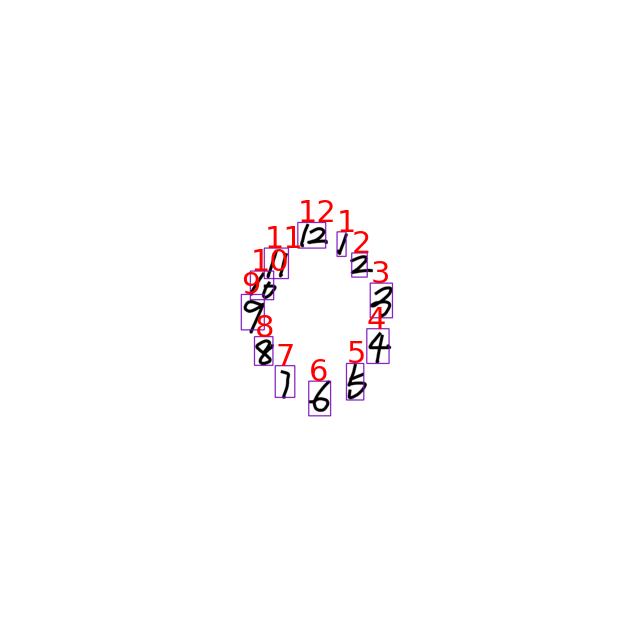

In [190]:
#image= cv2.imread(img_path)
plt.figure(figsize=(8,8))
for rect, digitPre in zip(rects, predNum):
        x = rect[0] + rect[2] / 2
        y = rect[1] + rect[3] / 2
        img = cv2.rectangle(image, (int(rect[0]), int(rect[1])), (int(rect[0]) + int(rect[2]),
                            int(rect[1]) + int(rect[3])), color= (121, 11, 189),  thickness=2)
        point = (int(rect[0]), int(rect[1]))
        
        plt.annotate(str(int(digitPre)), xy=point, fontsize = 22, color = 'red')
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.show()

In [14]:
from plot.appDataPreprocess import processJson, plotImg, rescaleCoordinate
import json

In [162]:
with open("../../DATA/appTest/clock_number.txt", "r") as f:
    numberData = f.read()
numberData = json.loads(numberData)
numberData = json.loads(numberData)

In [163]:
numX, numY = processJson(numberData)

left_up_corner, width, height, resultX_scaled, resultY_scaled = rescaleCoordinate(numX, numY)
resultX_scaled = [x for x in resultX_scaled]
resultY_scaled = [y for y in resultY_scaled]
#img_path =  folder + '/' + file_path +'.jpg' 

scaled_width, scaled_height, img = plotImg(resultX_scaled, resultY_scaled, line_width = 12,
                                                save_fig = False, 
                                                imgPath = '../../DATA/appTest/test_11.jpg')

In [164]:
max_h = 0
for row in resultY_scaled:
    tmp = max(row) - min(row)
    if tmp > max_h:
        max_h = tmp
scale = 0.17 / (max_h / 8)

In [165]:
# read image
old_image_height, old_image_width, channels = img.shape

# create new image of desired size and color (blue) for padding
new_image_width = int(1600 / scale)
new_image_height = int(1600 / scale)
color = (255,255,255)
result = np.full((new_image_height,new_image_width, channels), color, dtype=np.uint8)

# compute center offset
x_center = (new_image_width - old_image_width) // 2
y_center = (new_image_height - old_image_height) // 2

# copy img image into center of result image
result[y_center:y_center+old_image_height, 
       x_center:x_center+old_image_width] = img
       
# save result
cv2.imwrite("../../DATA/appTest/test_11.jpg", result)

True

In [131]:
max_h/ 8

0.17363759087307507